In [81]:
from matplotlib import pyplot as plt
import torch
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from models import conv_relu, train_model, DEFAULT_DEVICE
from dataset import load_dataset
from visualization import classes_to_image, high_dimensional_to_rgb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
def clear_ticks(ax):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

def show_example(x, y, prediction=None):
    cols = 2 if prediction is None else 3
    
    plt.subplot(1, cols, 1)
    plt.title('Satellite image')
    plt.axis('off')
    plt.imshow(high_dimensional_to_rgb(np.array(x)))
    
    ax1 = plt.subplot(1, cols, 2)
    plt.title('Ground truth')
    clear_ticks(ax1)
    plt.imshow(classes_to_image(np.array(y)))

    if prediction is not None:
        ax2 = plt.subplot(1, 3, 3)
        plt.title('Model output')
        plt.imshow(classes_to_image(np.array(prediction)))
        clear_ticks(ax2)

    plt.show()
    
def to_numpy(a):
    return a.detach().numpy()

In [113]:
def plot_history(loss_history, train_history, val_history, lr, acc=False, f1=False, kappa=True):
    plt.title(f"Training loss (lr = {lr:.5f}, final loss: {loss_history[-1]:.5f})")
    plt.ylim([0, 1])
    plt.plot(loss_history)
    plt.show()
    
    plt.title(f'Evaluation history')
    plt.ylim(top=1)

    if acc:
        plt.plot(train_history.accuracy, 'bo--', label='Train accuracy')
        plt.plot(val_history.accuracy, 'go--', label='Val accuracy')
        
    if f1:
        plt.plot(train_history.f1, 'bv--', label='Train F1')
        plt.plot(val_history.f1, 'gv--', label='Val F1')
        
    if kappa:
        plt.plot(train_history.kappa, 'bs--', label='Train kappa')
        plt.plot(val_history.kappa, 'gs--', label='Val kappa')
        
    plt.legend()
    plt.show()

# Load dataset and visualize random examples

In [7]:
d = load_dataset("dataset.hdf5", normalize=True)

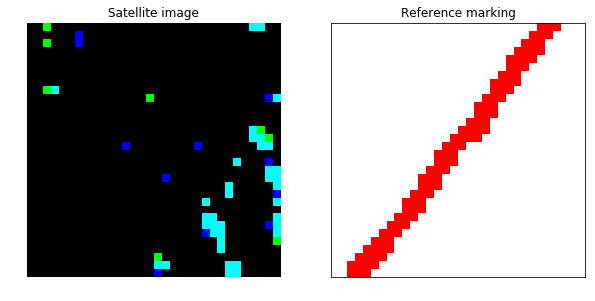

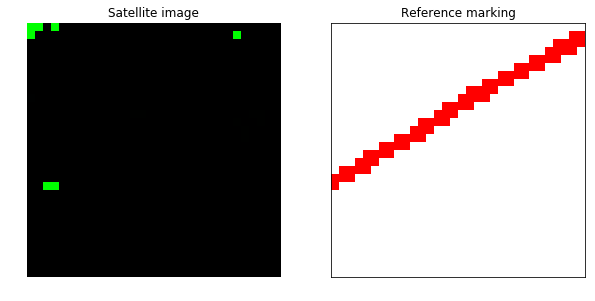

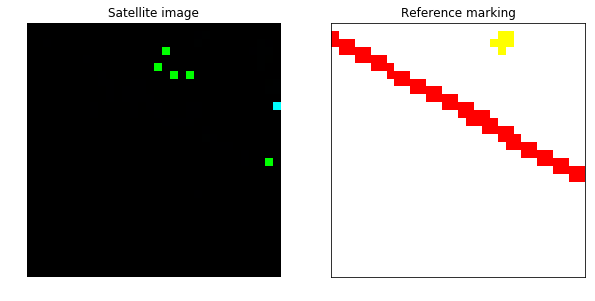

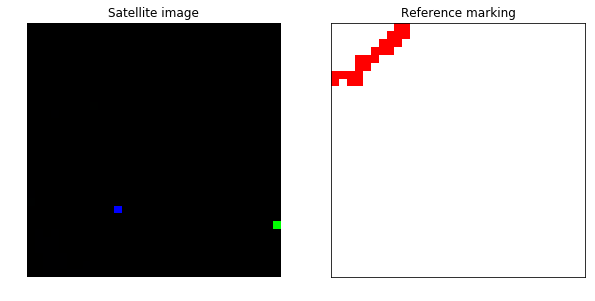

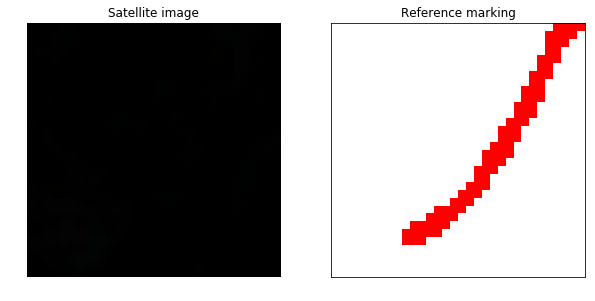

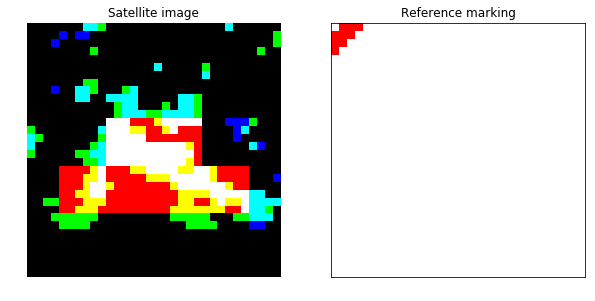

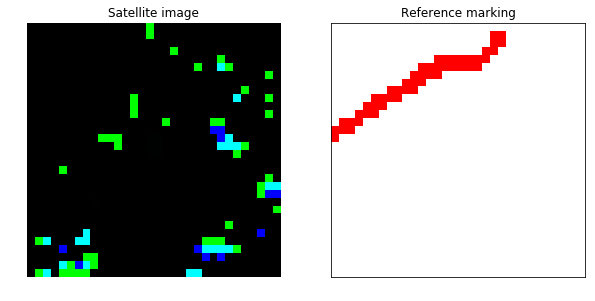

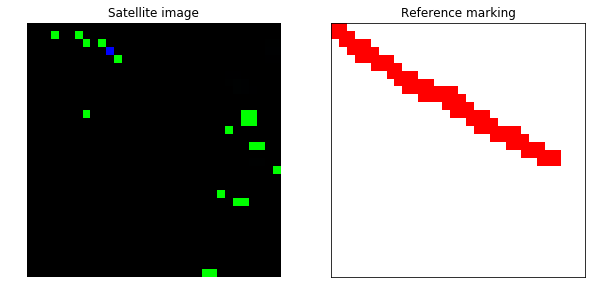

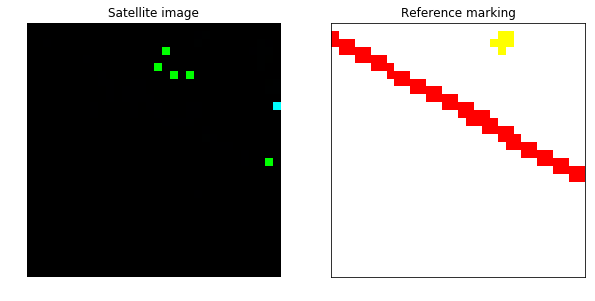

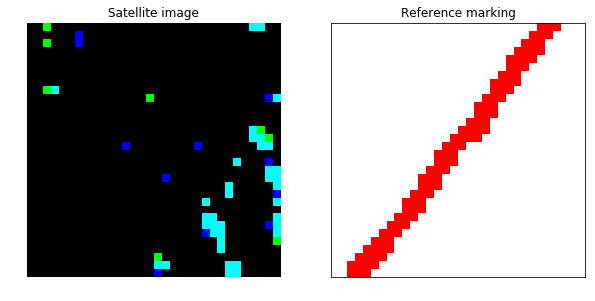

In [73]:
EXAMPLES = 10

while EXAMPLES > 0:
    idx = np.random.randint(0, len(d.train))
    (x, y) = d.train[idx]
    
    if (np.array(y).argmax(axis=0) == 1).sum() == 0:
        continue
      
    show_example(x, y)
    EXAMPLES -= 1

# Create and train model

In [9]:
model = conv_relu(d.input_bands, 3, n_filters=64, kernel_size=5, layers=6)

236/1331 training examples are non-empty
67/332 validation examples are non-empty
Epoch 1


/home/gpoesia/openafro/models.py:79: RuntimeWarning: invalid value encountered in true_divide
  precision = stats.tp / (stats.tp + stats.fp)


Iteration 0, loss=2.1672000885009766, prec=[0.943,1.000,0.000]/[0.945,1.000,1.000], recall=[1.000,0.000,0.000]/[1.000,0.000,0.000], acc=0.962/0.964, f1=0.000/0.000, kappa=0.333/0.333, 
Epoch 2
Epoch 3
Iteration 16, loss=0.2226828783750534, prec=[0.943,1.000,1.000]/[0.945,1.000,1.000], recall=[1.000,0.000,0.000]/[1.000,0.000,0.000], acc=0.962/0.964, f1=0.000/0.000, kappa=0.333/0.333, 
Epoch 4
Epoch 5
Iteration 32, loss=0.20768673717975616, prec=[0.943,1.000,1.000]/[0.945,1.000,1.000], recall=[1.000,0.000,0.000]/[1.000,0.000,0.000], acc=0.962/0.964, f1=0.000/0.000, kappa=0.333/0.333, 
Epoch 6
Epoch 7
Epoch 8
Iteration 6, loss=0.2436973750591278, prec=[0.943,0.643,1.000]/[0.945,0.000,1.000], recall=[1.000,0.001,0.000]/[1.000,0.000,0.000], acc=0.962/0.963, f1=0.000/0.000, kappa=0.334/0.333, 
Epoch 9
Epoch 10
Iteration 22, loss=0.18409956991672516, prec=[0.945,0.819,0.680]/[0.946,0.366,0.000], recall=[1.000,0.036,0.015]/[0.999,0.011,0.000], acc=0.963/0.963, f1=0.061/0.000, kappa=0.374/0.344

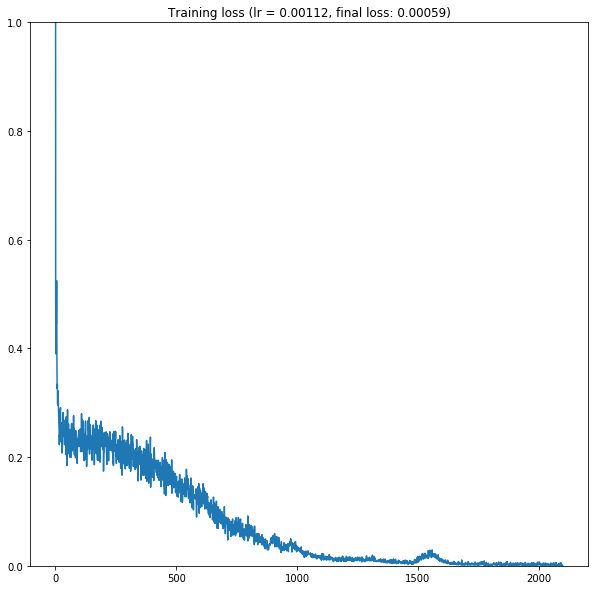

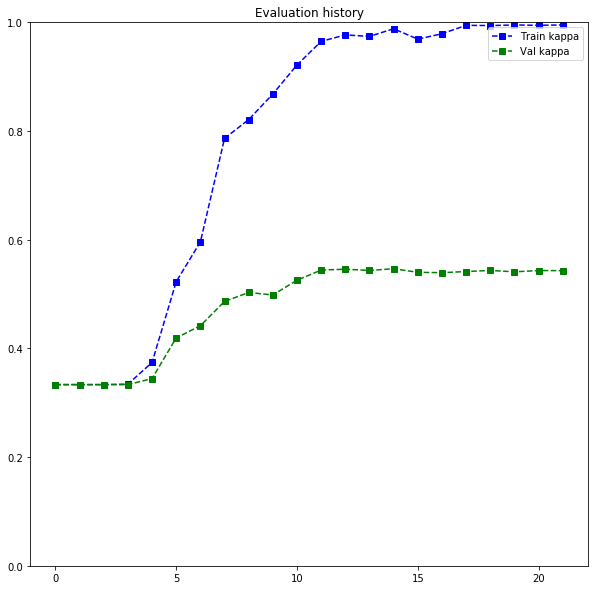

In [117]:
EPOCHS = 50
lrs = [0.0011157142695375642] # 10**np.random.uniform(-5, -2, 10)

points = []

for lr in lrs:
    loss_history, train_history, val_history, examples = train_model(model, d.train, d.val, lr, epochs=EPOCHS, dtype=torch.float32, batch_size=32, verbose=True)
    points.append((lr, loss_history[-1]))
    print("lr =", lr, "loss =", loss_history[-1])

    plot_history(loss_history, train_history, val_history, lr)

# Learning rate vs final loss

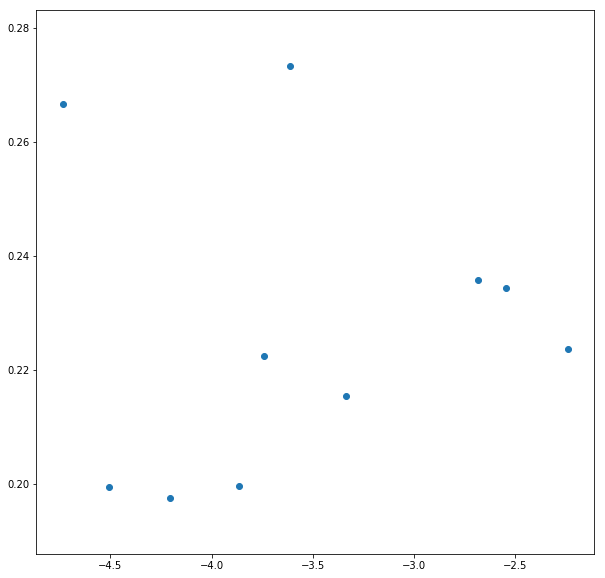

In [155]:
plt.scatter(x = np.log10([p[0] for p in points]), y = [p[1] for p in points], )

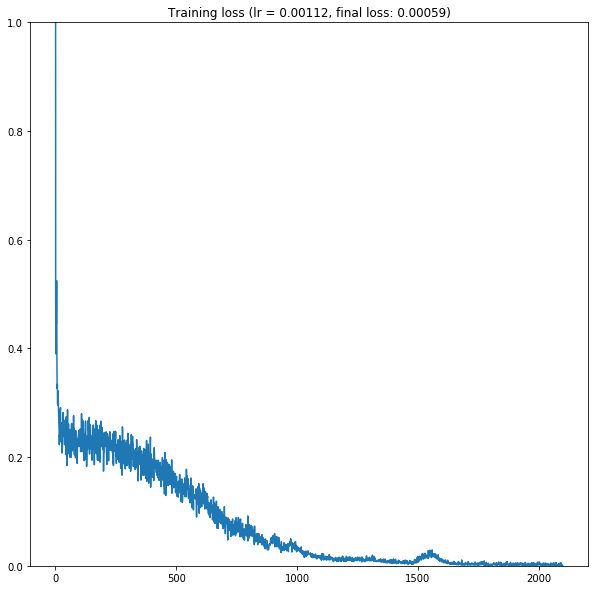

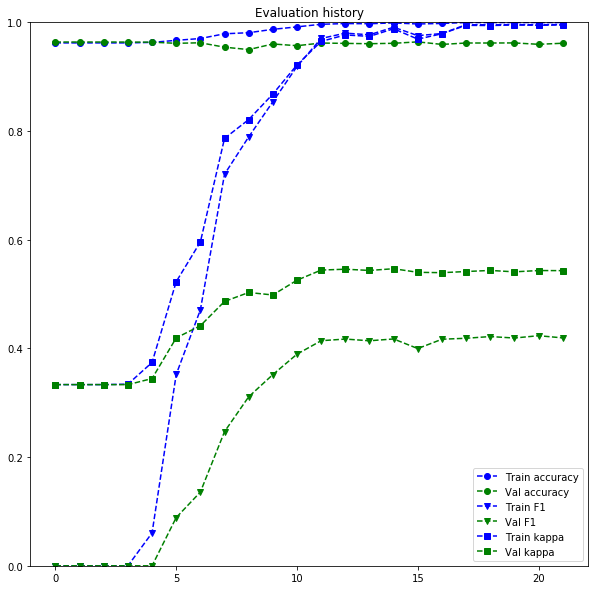

In [119]:
plot_history(loss_history, train_history, val_history, lr, acc=True, f1=True, kappa=True)

# Visualize predictions

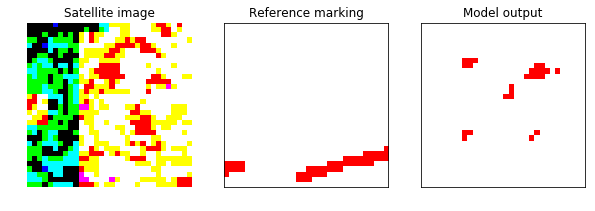

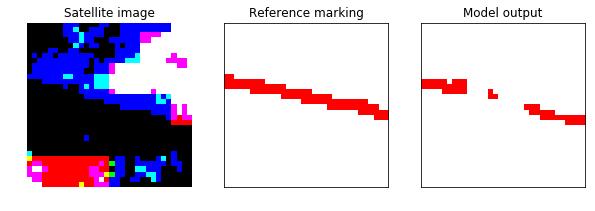

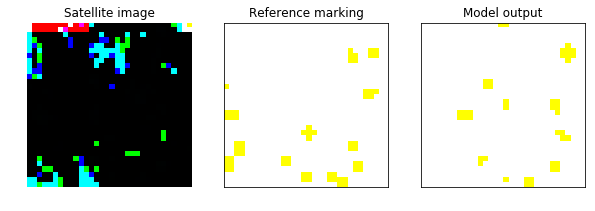

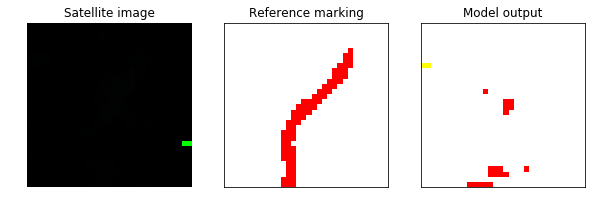

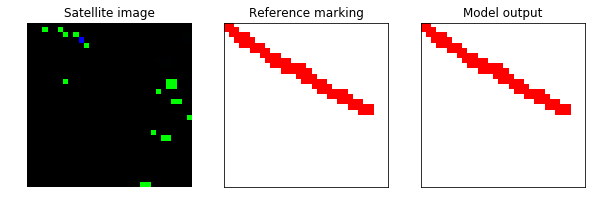

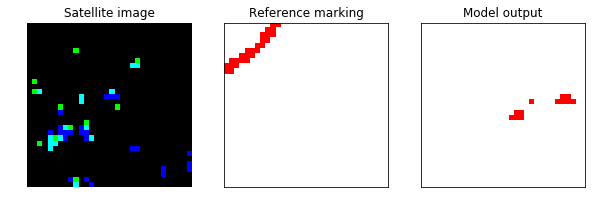

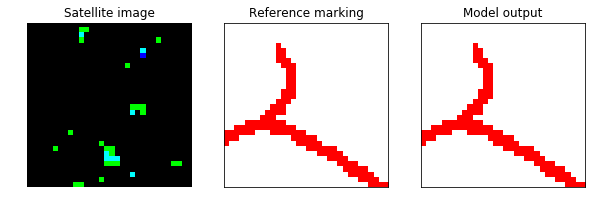

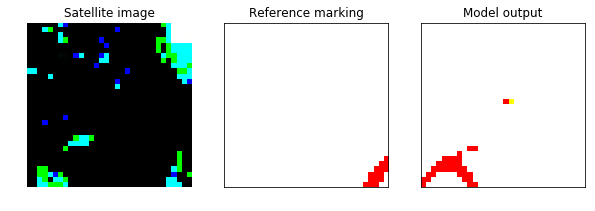

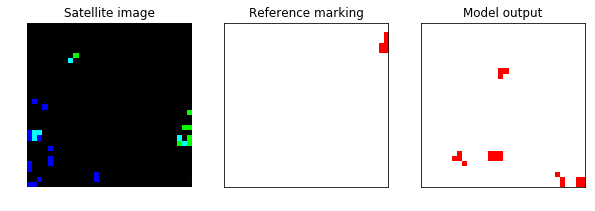

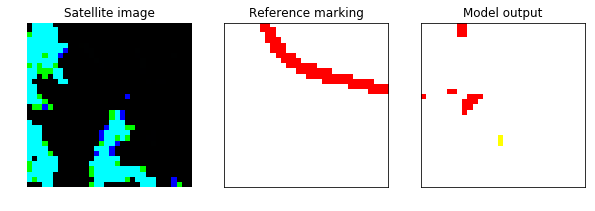

In [120]:
use_validation_set = True
EXAMPLES = 10

ds = d.val if use_validation_set else d.train

model.eval()

with torch.no_grad():
    while EXAMPLES > 0:
        if use_validation_set:
            idx = np.random.randint(0, len(ds))
        else:
            idx = examples[EXAMPLES - 1]

        (x, y) = ds[idx]

        if (np.array(y) != 0).sum() == 0:
            continue

        x = torch.Tensor(x.reshape(1, x.shape[0], x.shape[1], x.shape[2])).to(device=DEFAULT_DEVICE)

        prediction = to_numpy(model(x).cpu())[0].argmax(axis=0)

        show_example(x[0].cpu(), y, prediction)
        EXAMPLES -= 1